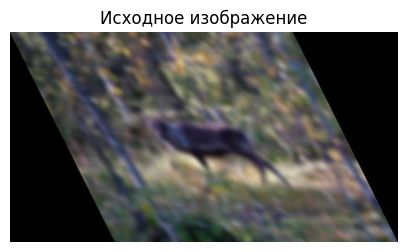

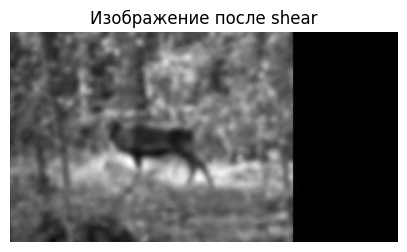

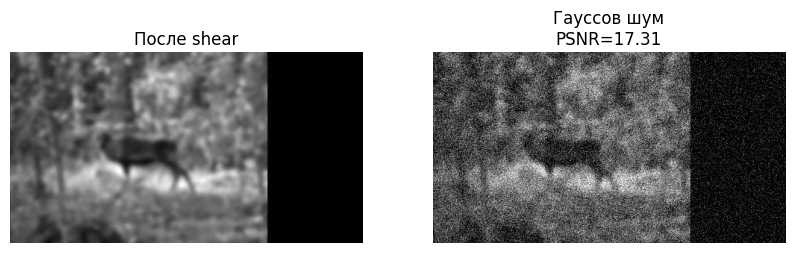

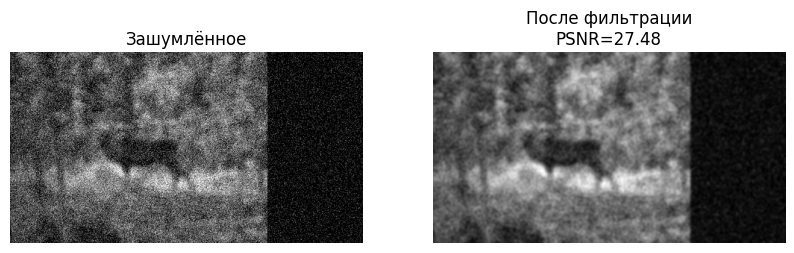

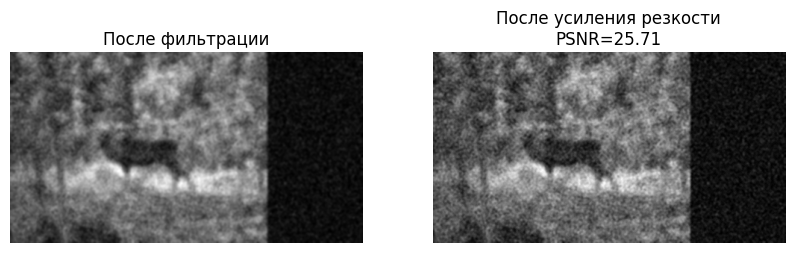

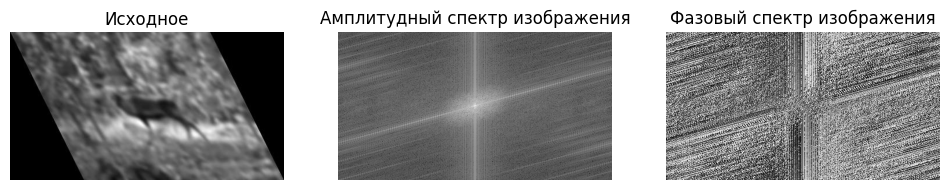

In [28]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [6, 4]

# Метрики качества
def getPSNR(I1, I2):
    s1 = cv2.absdiff(I1, I2)
    s1 = np.float32(s1) ** 2
    sse = s1.sum()
    if sse < 1e-10:
        return 0
    mse = sse / np.prod(I1.shape)
    return 10 * np.log10((255 ** 2) / mse)


def getSSIM(i1, i2):
    C1, C2 = 6.5025, 58.5225
    I1, I2 = np.float32(i1), np.float32(i2)

    mu1 = cv2.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv2.GaussianBlur(I2, (11, 11), 1.5)

    sigma1 = cv2.GaussianBlur(I1 * I1, (11, 11), 1.5) - mu1 ** 2
    sigma2 = cv2.GaussianBlur(I2 * I2, (11, 11), 1.5) - mu2 ** 2
    sigma12 = cv2.GaussianBlur(I1 * I2, (11, 11), 1.5) - mu1 * mu2

    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1 + sigma2 + C2))
    return cv2.mean(ssim_map)[0]


# Вспомогательные функции
def show(img, title='', cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')


# Геометрическое преобразование (SHEAR)
def shear_image(image, shear_x=0.0, shear_y=0.0):
    """
    Наклон изображения (shear)
    shear_x = -0.5 означает наклон на 50% по X
    """
    h, w = image.shape[:2]

    M = np.float32([
        [1, shear_x, 0],
        [shear_y, 1, 0]
    ])

    return cv2.warpAffine(image, M, (w, h))


# Шумы
def add_gauss_noise(image, mean=0, sigma=0.15):
    image = image.astype(np.float32) / 255
    noise = np.random.normal(mean, sigma, image.shape)
    out = np.clip(image + noise, 0, 1)
    return np.uint8(out * 255)


def add_salt_pepper(image, fraction=0.1):
    noisy = image.copy()
    h, w = image.shape
    num = int(fraction * h * w)

    coords = np.random.randint(0, h, num), np.random.randint(0, w, num)
    noisy[coords] = 255
    coords = np.random.randint(0, h, num), np.random.randint(0, w, num)
    noisy[coords] = 0
    return noisy


# Загрузка изображения
image = cv2.imread('lab3image.jpg')

if image is None:
    raise FileNotFoundError('Изображение lab3image.jpg не найдено')

rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(5, 4))
show(rgb, 'Исходное изображение')
plt.show()


# НАКЛОН (SHEAR) — ПЕРВЫЙ ЭТАП
sheared = shear_image(gray, shear_x=-0.5)

plt.figure(figsize=(5, 4))
show(sheared, 'Изображение после shear', 'gray')
plt.show()


# ДОБАВЛЕНИЕ ШУМА
gauss = add_gauss_noise(sheared, 0, 0.15)

plt.figure(figsize=(10, 4))
plt.subplot(121); show(sheared, 'После shear', 'gray')
plt.subplot(122); show(gauss, f'Гауссов шум\nPSNR={getPSNR(sheared, gauss):.2f}', 'gray')
plt.show()


# ФИЛЬТРАЦИЯ
filtered = cv2.GaussianBlur(gauss, (7, 7), 0)

plt.figure(figsize=(10, 4))
plt.subplot(121); show(gauss, 'Зашумлённое', 'gray')
plt.subplot(122); show(filtered, f'После фильтрации\nPSNR={getPSNR(sheared, filtered):.2f}', 'gray')
plt.show()


# УСИЛЕНИЕ РЕЗКОСТИ
sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

sharpened = cv2.filter2D(filtered, -1, sharpen_kernel)

plt.figure(figsize=(10, 4))
plt.subplot(121); show(filtered, 'После фильтрации', 'gray')
plt.subplot(122); show(sharpened, f'После усиления резкости\nPSNR={getPSNR(sheared, sharpened):.2f}', 'gray')
plt.show()


# ИТОГ
dft = cv.dft(np.float32(gray), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shift[..., 0], dft_shift[..., 1]))
phase_spectrum = cv.phase(dft_shift[..., 1], dft_shift[..., 0])
plt.figure(figsize=(12, 4))
plt.subplot(131); show(gray, 'Исходное', 'gray')
plt.subplot(132); show(sheared, 'После shear', 'gray')
plt.subplot(133); show(sharpened, 'Итоговое улучшенное', 'gray')
plt.subplot(132), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Амплитудный спектр изображения'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(phase_spectrum, cmap='gray')
plt.title('Фазовый спектр изображения'), plt.xticks([]), plt.yticks([])
plt.show()
